## Libraries

In [81]:
import os
import glob
from pathlib import Path
import random
from collections import Counter # contare (query sql)
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.utils import plot_model

import librosa
from IPython.display import Audio

## Load dataset

### Dani

In [ ]:
# Montaggio di Google Drive

from google.colab import drive
drive.mount('/content/drive')

In [13]:
from pathlib import Path

# possibili path (o hai il dataset su drive, o nella working directory)
drive_path = Path('/content/drive/MyDrive/music_dataset') # dani (o metti mini_dataset_100 se vuoi usare il mini-dataset)
local_path = Path('./music_dataset') # tommaso

# automaticamente scelgo path esistente
if drive_path.exists():
    DATA_PATH = drive_path
elif local_path.exists():
    DATA_PATH = local_path
else:
    raise FileNotFoundError(
        f"Nessun dataset trovato in {drive_path} né in {local_path}"
    )

# trovo filepaths (lista dei file .wav) e labels (le y)
filepaths = list(DATA_PATH.rglob('*.wav'))
labels = [p.parent.name for p in filepaths]

print(f"Trovati {len(filepaths)} file audio di {len(set(labels))} classi.")
print(f"Classi: {sorted(set(labels))}")

Trovati 42311 file audio di 28 classi.
Classi: ['Accordion', 'Acoustic_Guitar', 'Banjo', 'Bass_Guitar', 'Clarinet', 'Cymbals', 'Dobro', 'Drum_set', 'Electro_Guitar', 'Floor_Tom', 'Harmonica', 'Harmonium', 'Hi_Hats', 'Horn', 'Keyboard', 'Mandolin', 'Organ', 'Piano', 'Saxophone', 'Shakers', 'Tambourine', 'Trombone', 'Trumpet', 'Ukulele', 'Violin', 'cowbell', 'flute', 'vibraphone']


In [3]:
filepaths

[WindowsPath('music_dataset/Accordion/100.wav'),
 WindowsPath('music_dataset/Accordion/1000.wav'),
 WindowsPath('music_dataset/Accordion/1001.wav'),
 WindowsPath('music_dataset/Accordion/1002.wav'),
 WindowsPath('music_dataset/Accordion/1003.wav'),
 WindowsPath('music_dataset/Accordion/1004.wav'),
 WindowsPath('music_dataset/Accordion/1005.wav'),
 WindowsPath('music_dataset/Accordion/1006.wav'),
 WindowsPath('music_dataset/Accordion/1007.wav'),
 WindowsPath('music_dataset/Accordion/1008.wav'),
 WindowsPath('music_dataset/Accordion/1009.wav'),
 WindowsPath('music_dataset/Accordion/101.wav'),
 WindowsPath('music_dataset/Accordion/1010.wav'),
 WindowsPath('music_dataset/Accordion/1011.wav'),
 WindowsPath('music_dataset/Accordion/1012.wav'),
 WindowsPath('music_dataset/Accordion/1013.wav'),
 WindowsPath('music_dataset/Accordion/1014.wav'),
 WindowsPath('music_dataset/Accordion/1015.wav'),
 WindowsPath('music_dataset/Accordion/1016.wav'),
 WindowsPath('music_dataset/Accordion/1017.wav'),
 W

## Data Analysis

In [14]:
from collections import Counter # hashmap utile

# Numero campioni audio per classe

counts = Counter(labels) # hashmap {classe:#esempi}

for classe, count in counts.items():
    print(f"{classe}: {count}")

# problema: class imbalance
# possiamo risolvere con oversampling delle classi con meno esempi, 
# o direttamente allenando le reti pesando le classi in base a quanti esempi hanno

Accordion: 3581
Acoustic_Guitar: 3654
Banjo: 2998
Bass_Guitar: 3613
Clarinet: 634
cowbell: 621
Cymbals: 208
Dobro: 487
Drum_set: 3648
Electro_Guitar: 1316
Floor_Tom: 406
flute: 3719
Harmonica: 131
Harmonium: 1314
Hi_Hats: 444
Horn: 1258
Keyboard: 2041
Mandolin: 2458
Organ: 1442
Piano: 575
Saxophone: 454
Shakers: 1357
Tambourine: 558
Trombone: 2965
Trumpet: 503
Ukulele: 790
vibraphone: 506
Violin: 630


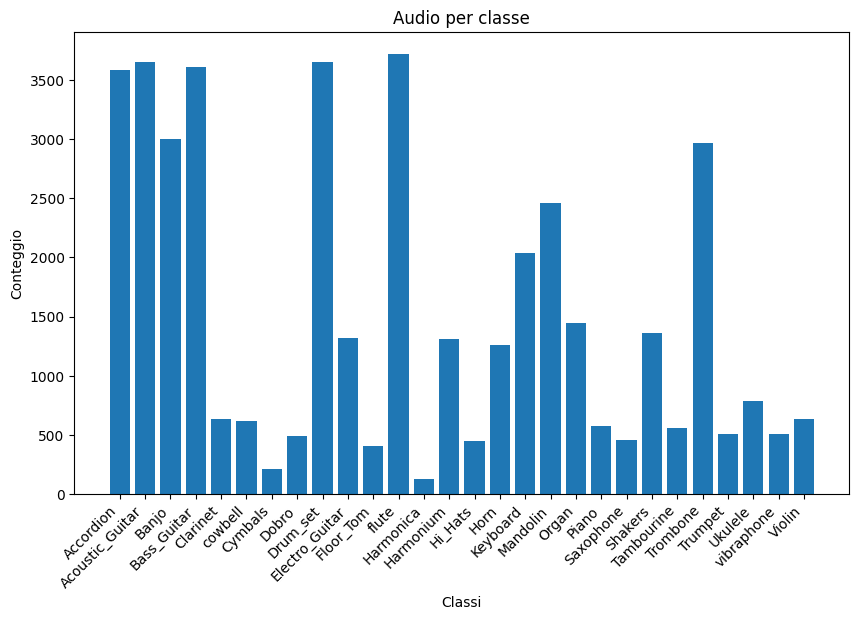

In [15]:
# Plot numero di audio per classe

plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values())
plt.title('Audio per classe')
plt.xlabel('Classi')
plt.ylabel('Conteggio')
plt.xticks(rotation=45, ha='right')
plt.show()

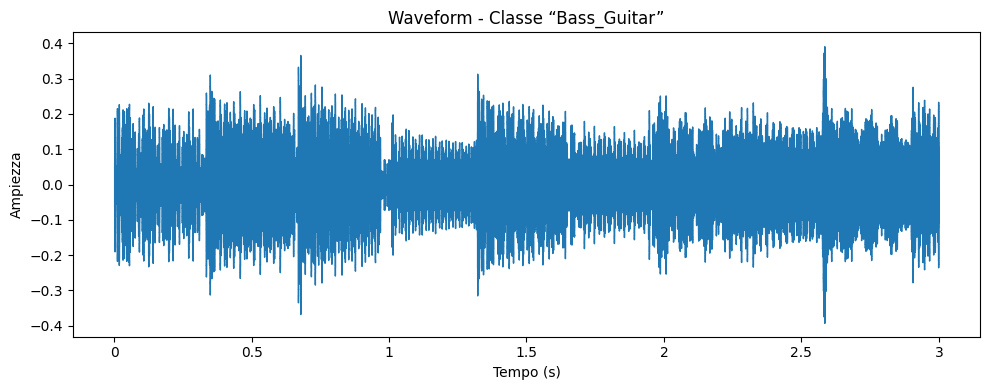

In [16]:
# prendo audio random, visualizziamo waveform e lo ascoltiamo

idx = random.randint(0,len(filepaths)) # indice random
sample_path = filepaths[idx] # audio
sample_label = labels[idx] # label

y, sr = librosa.load(sample_path, sr=None) # load audio
display(Audio(y, rate=sr)) # ascolto

# plot waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform - Classe “{sample_label}”")
plt.xlabel("Tempo (s)")
plt.ylabel("Ampiezza")
plt.tight_layout()
plt.show()

In [72]:
# prova che tutti i file hanno dirata 3s

durations = [librosa.get_duration(path=f) for f in filepaths]
print("Min dur:", np.min(durations))
print("Max dur:", np.max(durations))
print("Mean dur:", np.mean(durations))

Min dur: 3.0
Max dur: 3.0
Mean dur: 3.0


## Prendo un mini-dataset del dataset (per fare test veloci)

In [17]:
import random

SEED = 69 # nice
random.seed(SEED)
np.random.seed(SEED)

N = 100 # Numero esempi per classe

mini_filepaths = []
mini_labels    = []

for cls in set(labels):
    cls_files = [f for f, lab in zip(filepaths, labels) if lab == cls] # Tutti i file di quella classe
    sampled = random.sample(cls_files, k=min(N, len(cls_files))) # Seleziono N file a caso
    mini_filepaths.extend(sampled)
    mini_labels.extend([cls] * len(sampled))

print(f"Totale file audio del mini-dataset: {len(mini_filepaths)}")

# uso il mini-dataset (commentare se si vuole mini-dataset a parte, senza sovrascrivere quello originale)
filepaths = mini_filepaths
labels = mini_labels

Totale file audio del mini-dataset: 2800


## Preprocessing

### train-val-test split

In [18]:
# split 80-10-10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X = filepaths
y = labels
SEED = 22

X, y = shuffle(X, y, random_state=SEED)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=SEED
)

print(f"Train: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Val: {len(X_val)} ({len(X_val)/len(X):.1%})")
print(f"Test: {len(X_test)} ({len(X_test)/len(X):.1%})")

Train: 2240 (80.0%)
Val: 280 (10.0%)
Test: 280 (10.0%)


### Feature Extraction (mfcc, mfcc_mean, mel_spectrogram)

In [ ]:
import numpy as np
import librosa

# prende in input un file audio, returns matrice con coefficienti mfcc
# matrice di shape (n_mfcc, T)
def extract_mfcc_matrix(audio, n_mfcc=40):

    y, sr = librosa.load(audio, mono=True) # carico audio
    mfccs = librosa.feature.mfcc(y=y, n_mfcc=n_mfcc) # calcolo matrice mfcc
    return mfccs


# collasso matrice in un vettore
# vettore di shape (n_mfcc), cioè trovo il coeff medio ed elimino l'asse temporale
def extract_mfcc_vector(audio, n_mfcc=13, sr=22050, duration=None):
    mfccs = extract_mfcc_matrix(audio, n_mfcc=n_mfcc) # funzione sopra
    mfccs_mean = np.mean(mfccs, axis=1) # calcolo vettore mfcc (media su asse temporale)
    return mfccs_mean

# TO-DO
def extract_mel_spectogram(audio, img_height=H, img_width=W){

    y, sr = librosa.load(audio, sr=None)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=img_height)
    spect_db = librosa.power_to_db(spect, ref=np.max)
    spect_norm = (spect_db - spect_db.min()) / (spect_db.max() - spect_db.min())
    spect_norm = spect_norm[:, :img_width]
    return spect_norm
}


In [34]:
# QUANTO METTERE COME N_MFCC? 13, 40, 60 ??

In [ ]:
# TO-DO, per ogni metodo di feature extraction (cerchiamo di preprocessare sempre nello stesso modo)

# preprocessing per le X: 1) feature extraction e 2) standardization

# 1) feature extraction (mfcc matrix)
X_train_features_mfcc_matrix = np.array([extract_mfcc_matrix(audio, n_mfcc=40) for audio in X_train]) # shape: (n_samples,n_mfcc,time_steps)
X_val_features_mfcc_matrix   = np.array([extract_mfcc_matrix(audio, n_mfcc=40) for audio in X_val])
X_test_features_mfcc_matrix  = np.array([extract_mfcc_matrix(audio, n_mfcc=40) for audio in X_test])

# 2) standardization (non posso usare lo StandardScaler() perché vuole un array 2D ma noi abbiamo array 3D,
# quindi standardizzo a mano solo sulle prime 2 dimensioni (n_samples,n_mfcc))
def standardization(X):
    mean = X.mean(axis=(1,2), keepdims=True)
    std  = X.std( axis=(1,2), keepdims=True) + 1e-6
    return (X - mean) / std

X_train_mfcc = standardization(X_train_features_mfcc_matrix)
X_val_mfcc   = standardization(X_val_features_mfcc_matrix)
X_test_mfcc  = standardization(X_test_features_mfcc_matrix)

print("Shapes after norm:", X_train_mfcc.shape, X_val_mfcc.shape, X_test_mfcc.shape)


# n_mfcc=40, mfcc_vector, mini_dataset -> 25s (VA VELOCIZZATA QUESTA FASE)

Shapes after norm: (2240, 40, 130) (280, 40, 130) (280, 40, 130)


In [41]:
# preprocessing per le y: ohe (le y sono categorical: es. "Violin")

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False, handle_unknown='error')

y_train_ohe = ohe.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_ohe   = ohe.transform(np.array(y_val).reshape(-1, 1))
y_test_ohe  = ohe.transform(np.array(y_test).reshape(-1, 1))

## Models

### CNN

In [ ]:
# aggiungo una dim
X_train_mfcc = X_train_mfcc[..., np.newaxis]  # (n_train, 40, T, 1)
X_val_mfcc   = X_val_mfcc[...,   np.newaxis]  # (n_val,   40, T, 1)
X_test_mfcc  = X_test_mfcc[...,  np.newaxis]  # (n_test,  40, T, 1)

# input che dobbiamo passare alla rete è la dim di un singolo campione ovviamente
input_shape = X_train_mfcc.shape[1:]  # (40, T, 1)

num_classes = len(set(y_train)) # 28 classi

In [ ]:
# classica cnn, ma aggiungo batch_norm () che fanno la differenza
model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [106]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [107]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 40, 130, 32)       320       
                                                                 
 batch_normalization_9 (Batc  (None, 40, 130, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 20, 65, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 20, 65, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 20, 65, 64)       256       
 chNormalization)                                                
                                                      

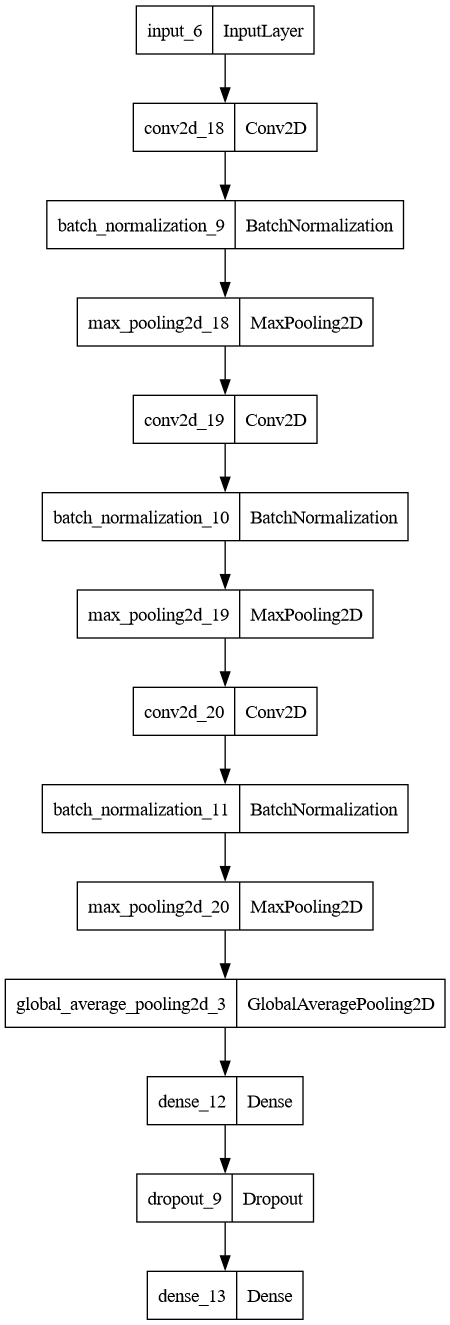

In [108]:
plot_model(model)

In [109]:
import tensorflow as tf

print("✅ TensorFlow version:", tf.__version__)
print("🖥️ GPU rilevate:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ La GPU è attiva e disponibile! 🚀")
else:
    print("❌ Nessuna GPU disponibile.")

✅ TensorFlow version: 2.10.1
🖥️ GPU rilevate: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ La GPU è attiva e disponibile! 🚀


In [110]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5, # mi fermo se per 5 epochs non miglioro
    restore_best_weights=True # ripristino pesi migliori (prima di overfittare)
)

mc = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss',
    save_best_only=True # salvo solo il modello con val_loss migliore
)


In [104]:
history = model.fit(
    X_train_mfcc, y_train_ohe,
    validation_data=(X_val_mfcc, y_val_ohe),
    epochs=50,
    batch_size=32,
    callbacks=[es, mc]  # callbacks
)

Epoch 1/50
70/70 [==============================] - 2s 19ms/step - loss: 3.7149 - accuracy: 0.0924 - val_loss: 7.7205 - val_accuracy: 0.0429
Epoch 2/50
70/70 [==============================] - 1s 16ms/step - loss: 2.8620 - accuracy: 0.1714 - val_loss: 15.0067 - val_accuracy: 0.0357
Epoch 3/50
70/70 [==============================] - 1s 17ms/step - loss: 2.6625 - accuracy: 0.2223 - val_loss: 14.9306 - val_accuracy: 0.0357
Epoch 4/50
70/70 [==============================] - 1s 17ms/step - loss: 2.5144 - accuracy: 0.2723 - val_loss: 8.5078 - val_accuracy: 0.0750
Epoch 5/50
70/70 [==============================] - 1s 18ms/step - loss: 2.3346 - accuracy: 0.3183 - val_loss: 5.9508 - val_accuracy: 0.2143
Epoch 6/50
70/70 [==============================] - 1s 18ms/step - loss: 2.2358 - accuracy: 0.3478 - val_loss: 4.2649 - val_accuracy: 0.2786
Epoch 7/50
70/70 [==============================] - 1s 17ms/step - loss: 2.0964 - accuracy: 0.3853 - val_loss: 2.9363 - val_accuracy: 0.3536
Epoch 8/50


In [ ]:
model.save('final_model.h5')

In [111]:
model = load_model('CNN_mfcc_mini_dataset.h5')

### Results (to-do)

In [112]:
test_loss, test_acc = model.evaluate(X_test_mfcc, y_test_ohe)

9/9 [==============================] - 0s 27ms/step - loss: 0.2744 - accuracy: 0.9286


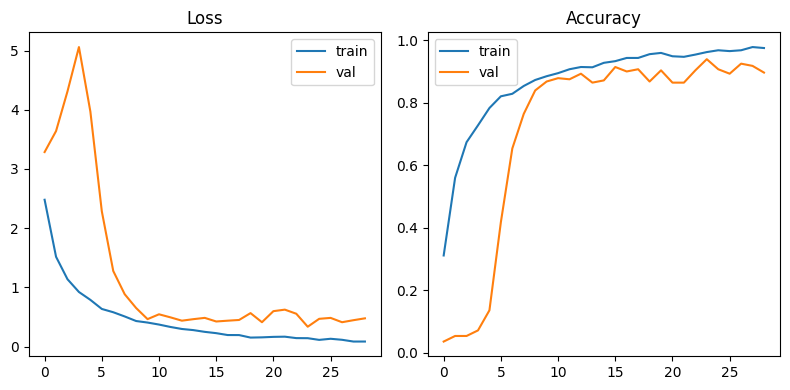

In [67]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [115]:
# sceglie un audio a caso dal test set, lo fa ascoltare, e mostra actual e predicted labels
def random_prediction():
    idx = random.randrange(len(X_test)) # indice random
    filepath = X_test[idx]
    true_label = y_test[idx]
    
    x_sample = X_test_mfcc[idx:idx+1]
    pred_prob = model.predict(x_sample)
    pred_idx = pred_prob.argmax(axis=1)[0]
    class_names = sorted(set(labels))
    pred_label = class_names[pred_idx]
    
    print(f"Indice campione: {idx}")
    print(f"Classe vera     : {true_label}")
    print(f"Classe predetta : {pred_label}\n")
    
    # 5) Riproduci l'audio
    display(Audio(filepath, autoplay=True))


random_prediction()

1/1 [==============================] - 0s 26ms/step
Indice campione: 133
Classe vera     : Trombone
Classe predetta : Trombone



In [68]:
y_pred_prob = model.predict(X_test_mfcc)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_ohe, axis=1)

9/9 [==============================] - 0s 48ms/step


In [71]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=ohe.categories_[0]))

report = classification_report(y_true, y_pred, target_names=sorted(set(labels)))
print("Classification Report:\n")
print(report)

Classification Report:

                 precision    recall  f1-score   support

      Accordion       0.77      1.00      0.87        10
Acoustic_Guitar       0.80      0.80      0.80        10
          Banjo       1.00      1.00      1.00        10
    Bass_Guitar       1.00      1.00      1.00        10
       Clarinet       0.89      0.80      0.84        10
        Cymbals       1.00      0.80      0.89        10
          Dobro       1.00      0.90      0.95        10
       Drum_set       1.00      1.00      1.00        10
 Electro_Guitar       1.00      0.90      0.95        10
      Floor_Tom       1.00      0.90      0.95        10
      Harmonica       1.00      1.00      1.00        10
      Harmonium       1.00      1.00      1.00        10
        Hi_Hats       0.71      1.00      0.83        10
           Horn       1.00      1.00      1.00        10
       Keyboard       1.00      1.00      1.00        10
       Mandolin       0.88      0.70      0.78        10
      

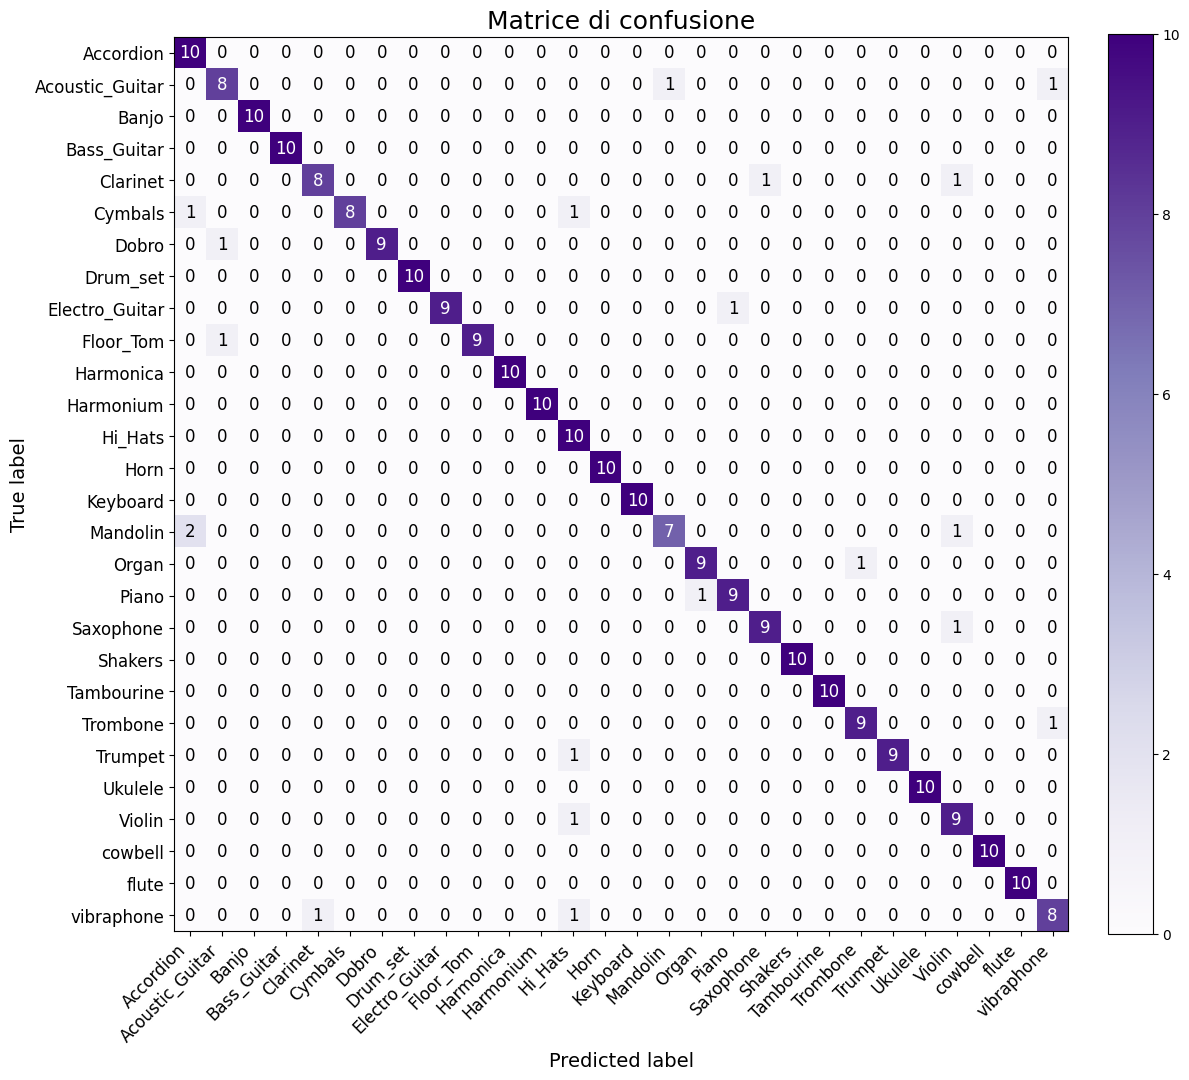

In [ ]:
# funzione Confusion Matrix di Dani
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
    plt.title("Matrice di confusione", fontsize=18)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    # Imposta ticks e labels
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names, fontsize=12)

    ax.set_ylabel('True label',   fontsize=14)
    ax.set_xlabel('Predicted label', fontsize=14)

    # Annotazioni sui quadrati
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        ax.text(j, i, f"{cm[i, j]}", ha="center", va="center", color=color, fontsize=12)

    plt.tight_layout()
    plt.show()


plot_confusion_matrix(y_true, y_pred, sorted(set(labels)))
